In [3]:
import os
from glob import glob
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import matplotlib .pyplot as plt


In [4]:
np.random.seed(42)
from sklearn.metrics import confusion_matrix

In [5]:
import keras
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from sklearn.model_selection import train_test_split
from scipy import  stats
from sklearn.preprocessing import LabelEncoder

In [6]:
skin_df=pd.read_csv('C:\VSCODE\Cancer Cell Detection\HAM10000_metadata.csv')
SIZE=32
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [7]:
le=LabelEncoder()
le.fit(skin_df['dx'])
LabelEncoder()
print(list(le.classes_))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [8]:
skin_df['label']=le.transform(skin_df["dx"])
print(skin_df.sample(10))

        lesion_id      image_id   dx    dx_type   age     sex  \
1617  HAM_0007180  ISIC_0033272  mel      histo  65.0    male   
8128  HAM_0007195  ISIC_0031923   nv      histo  40.0  female   
2168  HAM_0001835  ISIC_0026652  mel      histo  65.0    male   
1090  HAM_0000465  ISIC_0030583  bkl  consensus  35.0  female   
7754  HAM_0001720  ISIC_0034010   nv      histo  45.0    male   
8071  HAM_0006333  ISIC_0024424   nv      histo  35.0    male   
7423  HAM_0004548  ISIC_0032832   nv      histo  45.0  female   
8984  HAM_0006526  ISIC_0026671   nv      histo  55.0    male   
2310  HAM_0003102  ISIC_0032389  mel      histo  65.0    male   
7256  HAM_0004260  ISIC_0025525   nv      histo  65.0    male   

         localization  label  
1617             face      4  
8128  lower extremity      5  
2168             back      4  
1090            trunk      2  
7754          abdomen      5  
8071            trunk      5  
7423  upper extremity      5  
8984  lower extremity      5  
2310 

C:\Users\Rajesh\AppData\Local\Temp\ipykernel_1772\2001277157.py:19: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sample_age['age'],fit=stats.norm,color='red');


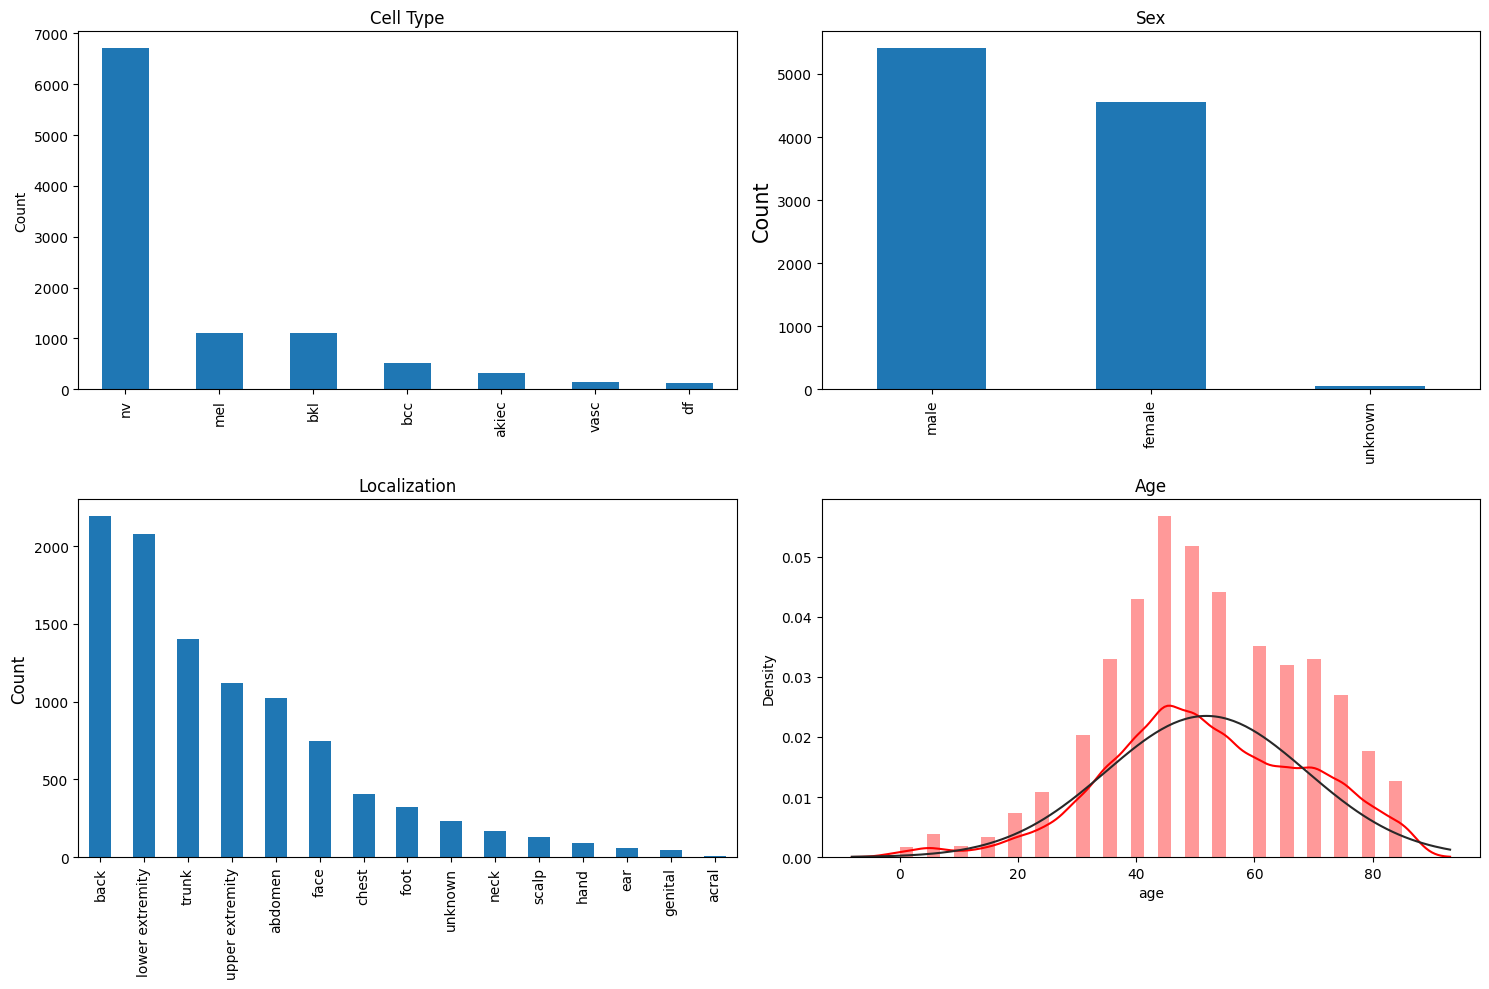

In [9]:
fig=plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(221)
skin_df['dx'].value_counts().plot(kind='bar',ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type');

ax2=fig.add_subplot(222)
skin_df['sex'].value_counts().plot(kind='bar',ax=ax2)
ax2.set_ylabel('Count',size=15)
ax2.set_title('Sex');

ax3=fig.add_subplot(223)
skin_df['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Count',size=12)
ax3.set_title('Localization')

ax4=fig.add_subplot(224)
sample_age=skin_df[pd.notnull(skin_df['age'])]
sns.distplot(sample_age['age'],fit=stats.norm,color='red');
ax4.set_title('Age')

plt.tight_layout()
plt.show()


In [10]:
from sklearn.utils import resample
print(skin_df['label'].value_counts())

5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: label, dtype: int64


In [11]:
df_0=skin_df[skin_df['label']==0]
df_1=skin_df[skin_df['label']==1]
df_2=skin_df[skin_df['label']==2]
df_3=skin_df[skin_df['label']==3]
df_4=skin_df[skin_df['label']==4]
df_5=skin_df[skin_df['label']==5]
df_6=skin_df[skin_df['label']==6]

n_samples=500
df_0_balanced=resample(df_0, replace=True, n_samples=n_samples, random_state=42)
df_1_balanced=resample(df_1, replace=True, n_samples=n_samples, random_state=42)
df_2_balanced=resample(df_2, replace=True, n_samples=n_samples, random_state=42)
df_3_balanced=resample(df_3, replace=True, n_samples=n_samples, random_state=42)
df_4_balanced=resample(df_4, replace=True, n_samples=n_samples, random_state=42)
df_5_balanced=resample(df_5, replace=True, n_samples=n_samples, random_state=42)
df_6_balanced=resample(df_6, replace=True, n_samples=n_samples, random_state=42)

skin_df_balanced=pd.concat([df_0_balanced, df_1_balanced, df_2_balanced, df_3_balanced, df_4_balanced, df_5_balanced, df_6_balanced])

print(skin_df_balanced['label'].value_counts())

0    500
1    500
2    500
3    500
4    500
5    500
6    500
Name: label, dtype: int64


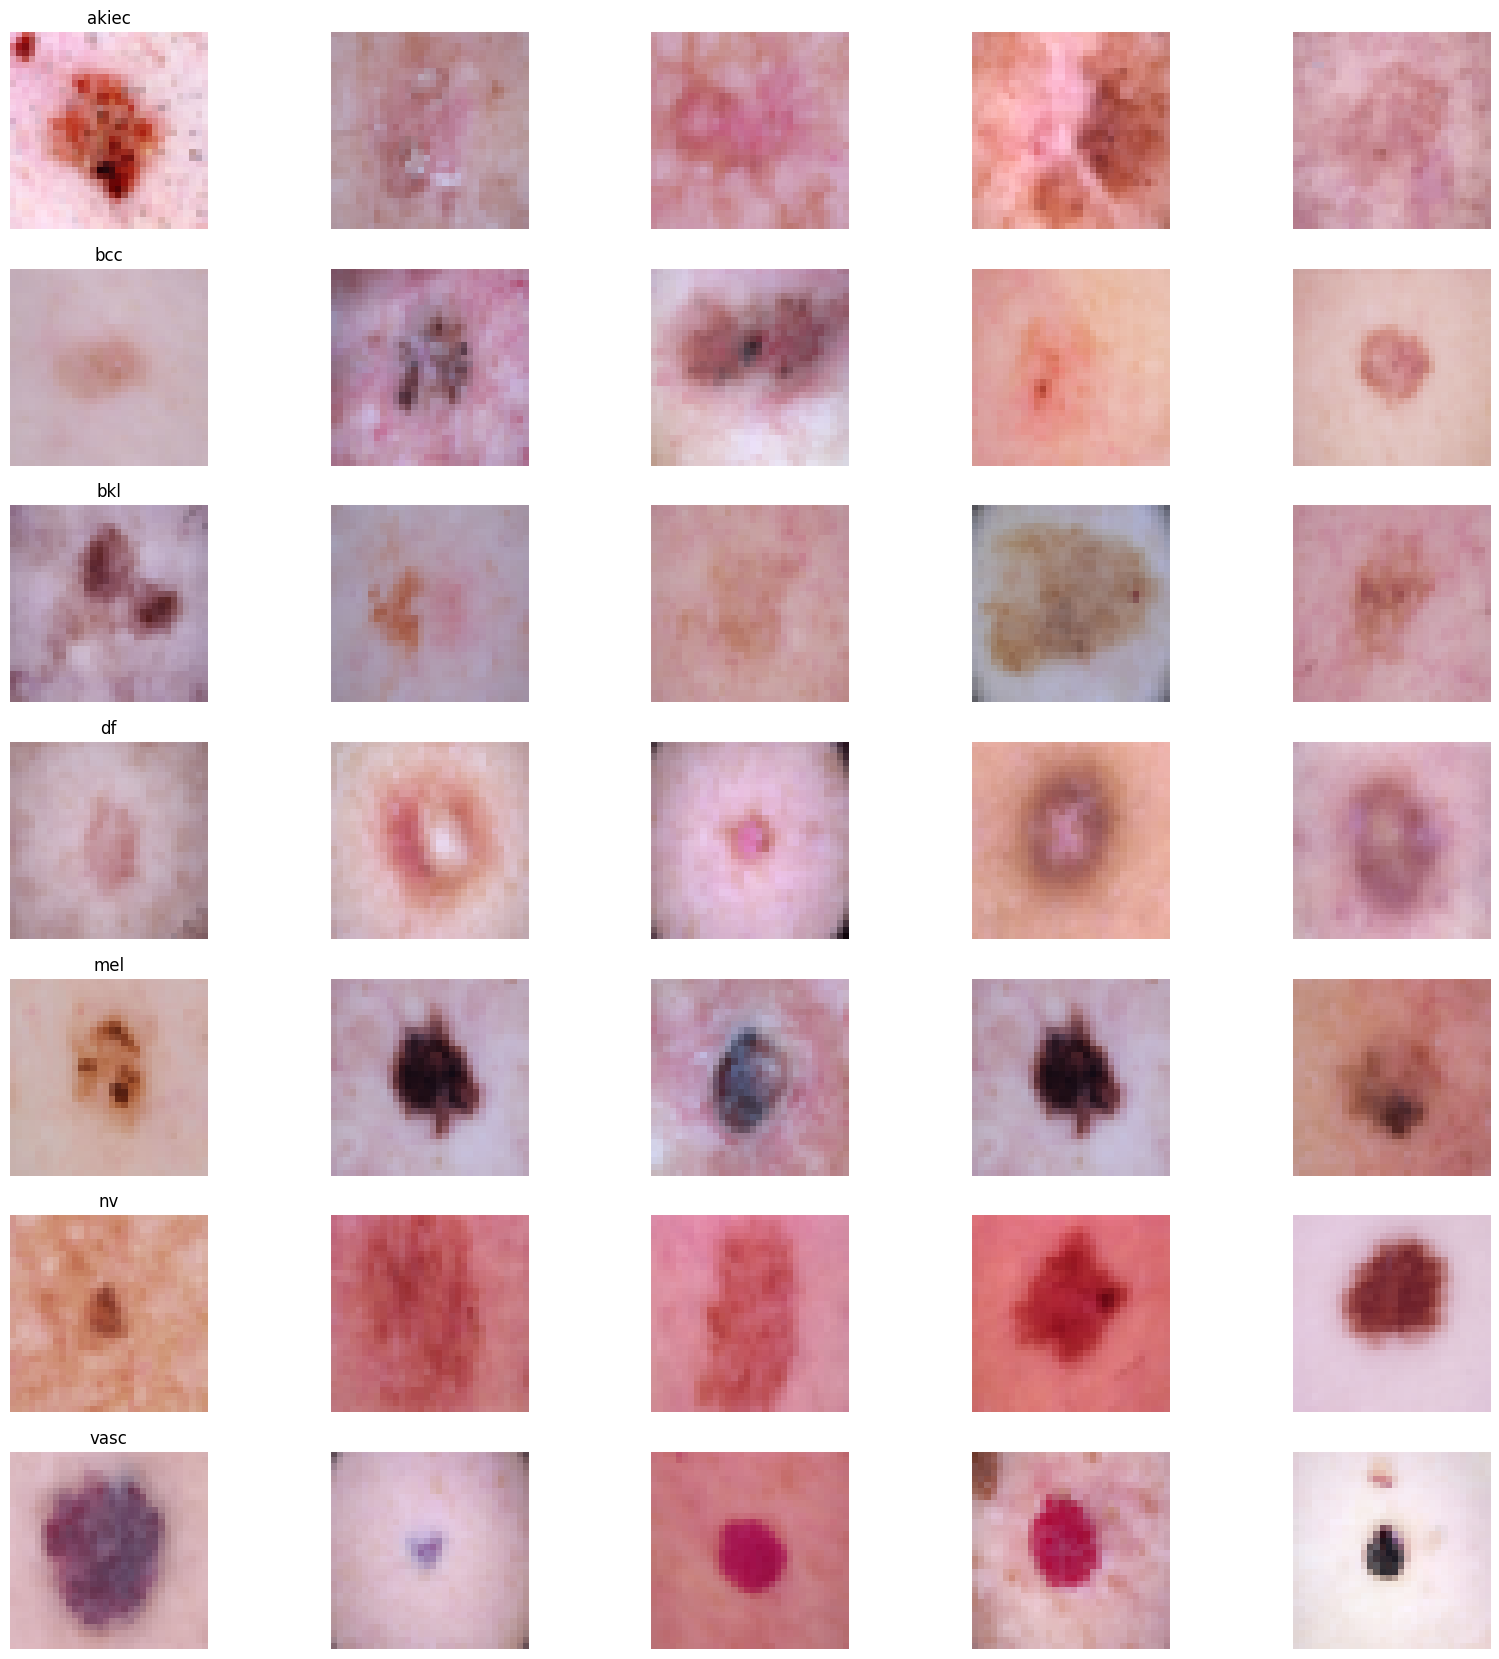

In [12]:
image_path={os.path.splitext(os.path.basename(x))[0]:x for x in glob(os.path.join('C:/VSCODE/Cancer Cell Detection/','*','*.jpg'))}

skin_df_balanced['path']=skin_df_balanced['image_id'].map(image_path.get)

skin_df_balanced['image']=skin_df_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))))

n_samples=5
fig, m_axs=plt.subplots(7, n_samples, figsize=(4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df_balanced.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

In [13]:
x=np.asarray(skin_df_balanced['image'].tolist())
x=x/255.
y=skin_df_balanced['label']
y_cat=to_categorical(y,num_classes=7)

In [14]:
x_train, x_test, y_train, y_test = train_test_split(x, y_cat, test_size=0.25, random_state=42)

In [15]:
num_classes = 7

model = Sequential()
model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(SIZE, SIZE, 3)))
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3),activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3),activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(32))
model.add(Dense(7, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 256)       7168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 256)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 256)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 128)       295040    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 128)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 128)         0

In [16]:
batch_size = 16 
epochs = 50

history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size = batch_size,
    validation_data=(x_test, y_test),
    verbose=2)

score = model.evaluate(x_test, y_test)
print('Test accuracy:', score[1])

Epoch 1/50
165/165 - 40s - loss: 1.9017 - acc: 0.1920 - val_loss: 1.7649 - val_acc: 0.3063 - 40s/epoch - 243ms/step
Epoch 2/50
165/165 - 39s - loss: 1.6019 - acc: 0.3528 - val_loss: 1.5375 - val_acc: 0.3680 - 39s/epoch - 239ms/step
Epoch 3/50
165/165 - 33s - loss: 1.5004 - acc: 0.3790 - val_loss: 1.4939 - val_acc: 0.4194 - 33s/epoch - 198ms/step
Epoch 4/50
165/165 - 31s - loss: 1.4556 - acc: 0.4050 - val_loss: 1.4144 - val_acc: 0.4206 - 31s/epoch - 186ms/step
Epoch 5/50
165/165 - 27s - loss: 1.4169 - acc: 0.4312 - val_loss: 1.3831 - val_acc: 0.4354 - 27s/epoch - 161ms/step
Epoch 6/50
165/165 - 23s - loss: 1.3796 - acc: 0.4545 - val_loss: 1.3768 - val_acc: 0.4823 - 23s/epoch - 139ms/step
Epoch 7/50
165/165 - 24s - loss: 1.3378 - acc: 0.4724 - val_loss: 1.3200 - val_acc: 0.4320 - 24s/epoch - 143ms/step
Epoch 8/50
165/165 - 22s - loss: 1.2946 - acc: 0.4922 - val_loss: 1.3735 - val_acc: 0.4251 - 22s/epoch - 136ms/step
Epoch 9/50
165/165 - 22s - loss: 1.2647 - acc: 0.5162 - val_loss: 1.2482

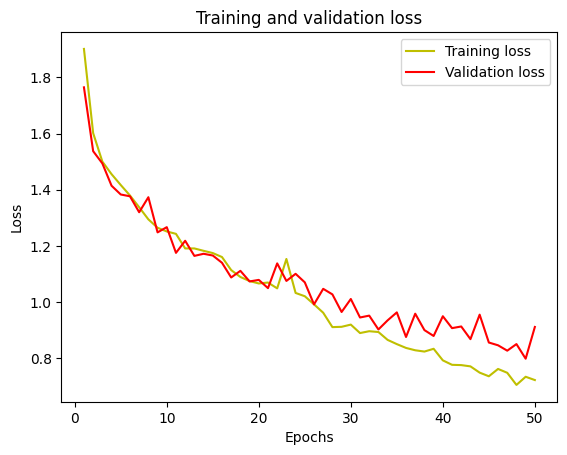

In [17]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

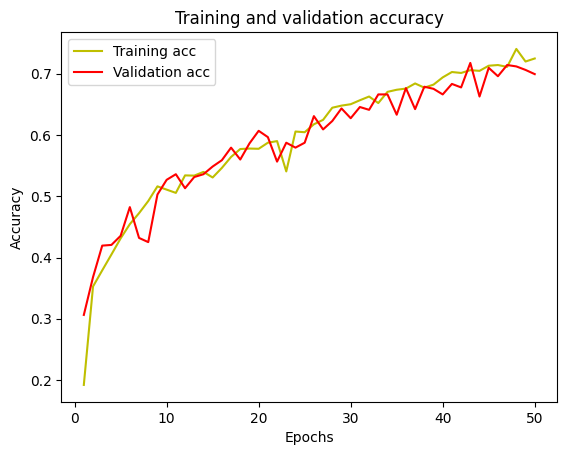

In [18]:
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [19]:
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis = 1)
y_true = np.argmax(y_test, axis = 1) 

28/28 [==============================] - 2s 76ms/step


In [20]:
cm = confusion_matrix(y_true, y_pred_classes)

<Axes: >

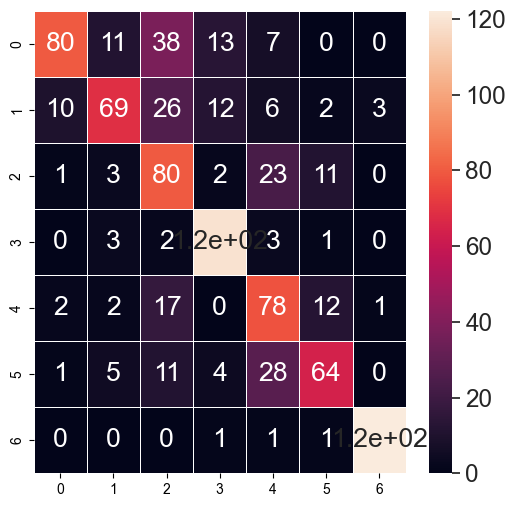

In [21]:
fig, ax = plt.subplots(figsize=(6,6))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)

Text(0, 0.5, 'Fraction of incorrect predictions')

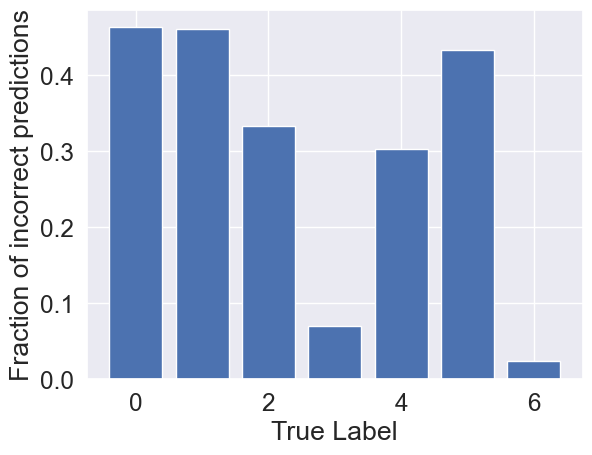

In [22]:
incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)
plt.bar(np.arange(7), incorr_fraction)
plt.xlabel('True Label')
plt.ylabel('Fraction of incorrect predictions')